Overview:

Anticipating what consumers will want and how much of it they will want is a difficult task in the field of supply chain management. Experts have historically estimated future demand using basic statistics and their intuition, particularly for smaller product categories with predictable demand trends.

Using data from 2015 to 2018, we will utilize Python in this project to create a model that forecasts the amount of our best-selling product that consumers will purchase over the following two years. However, there isn't a lot of information about 2018 in the data. Therefore, we will only take into account data up to 2017 and forecast for 2018 and 2019. The optimal inventory levels for that product, including when to place a new order and how much safety stock we require, will then be determined using this prediction.

Two important business questions will be addressed during this project:

1. What is the demand forecast for the
top-selling product in the next 24 months?
2. What is the product's ideal inventory level?

Importing Required Libraries

In [153]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from prophet import Prophet

import seaborn as sns
import matplotlib.pyplot as plt

EDA

In [154]:
df = pd.read_csv("dataset.csv", encoding="ISO-8859-1")
df.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [155]:
df["order date (DateOrders)"]= pd.to_datetime(df["order date (DateOrders)"])
df["shipping date (DateOrders)"] = pd.to_datetime(df["shipping date (DateOrders)"])

In [156]:
df = df[df["shipping date (DateOrders)"] < "2018-01-01"]
df['shipping date (DateOrders)'].sort_values().tail(5)

,shipping date (DateOrders)
93846,2017-12-31 22:17:00
20961,2017-12-31 22:38:00
41414,2017-12-31 22:49:00
28386,2017-12-31 23:52:00
88336,2017-12-31 23:52:00


In [157]:
df.describe()

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,...,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status,shipping date (DateOrders)
count,178150.000000,178150.000000,178150.000000,178150.000000,178150.000000,178150.000000,178150.000000,178147.000000,178150.000000,178150.000000,...,178150.000000,178150.000000,178150.000000,24840.000000,178150.000000,178150.000000,0.0,178150.000000,178150.0,178150
mean,3.496441,2.931709,22.034384,183.466378,0.548033,31.307814,6520.114286,35922.545353,5.419495,29.718439,...,204.171248,183.466378,22.034384,55426.132327,683.637171,31.307814,NaN,140.800064,0.0,2016-06-08 12:19:35.296772608
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,...,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0,2015-01-03 00:00:00
25%,2.000000,2.000000,7.200000,105.580002,0.000000,18.000000,3217.000000,725.000000,4.000000,18.265411,...,119.980003,105.580002,7.200000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0,2015-09-21 22:13:00
50%,3.000000,4.000000,31.730000,163.990005,1.000000,29.000000,6375.000000,19380.000000,5.000000,33.144863,...,199.919998,163.990005,31.730000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0,2016-06-08 04:52:00
75%,5.000000,4.000000,64.889999,247.399994,1.000000,45.000000,9662.000000,78201.000000,7.000000,39.279617,...,299.950012,247.399994,64.889999,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0,2017-02-23 00:52:30
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,18563.000000,99205.000000,12.000000,48.781933,...,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0,2017-12-31 23:52:00
std,1.623518,1.374694,104.552859,119.800990,0.497689,15.007266,3913.941020,37540.664232,1.590594,9.813081,...,132.002670,119.800990,104.552859,31919.279101,329.701138,15.007266,NaN,139.565670,0.0,NaN


From this we get:
1. There are 178150 orders made.
2. App 55% of orders had late delievery risks.
3. All the products are available.
4. 75% of customers bought goods worth at least $247.40.

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178150 entries, 48 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Type                           178150 non-null  object        
 1   Days for shipping (real)       178150 non-null  int64         
 2   Days for shipment (scheduled)  178150 non-null  int64         
 3   Benefit per order              178150 non-null  float64       
 4   Sales per customer             178150 non-null  float64       
 5   Delivery Status                178150 non-null  object        
 6   Late_delivery_risk             178150 non-null  int64         
 7   Category Id                    178150 non-null  int64         
 8   Category Name                  178150 non-null  object        
 9   Customer City                  178150 non-null  object        
 10  Customer Country               178150 non-null  object        
 11  Cust

Data Preprocessing:
Tasks:
*   Dropping irrelevant columns
*   Drop rows with missing values
*   Create new features
*   Convert categorical features to numerical features.

In [159]:
# Drop Irrelevant Columns:

def drop_columns(df, columns_to_drop):
  df = df.drop(columns=columns_to_drop)
  print(f"{len(columns_to_drop)} columns dropped successfully. Number of columns remaining: {len(df.columns)}")
  return df

columns_to_drop = ['Category Id', 'Customer Email', 'Customer Password', 'Customer Street', 'Customer Zipcode', 'Department Id', 'Latitude', 'Longitude', 'Order Customer Id', 'Order Item Cardprod Id', 'Order Item Product Price', 'Order Profit Per Order', 'Order Zipcode', 'Product Category Id', 'Product Description', 'Product Image']
df = drop_columns(df, columns_to_drop)

16 columns dropped successfully. Number of columns remaining: 37


Checking missing values

In [160]:
df.isnull().sum()

,0
Type,0
Days for shipping (real),0
Days for shipment (scheduled),0
Benefit per order,0
Sales per customer,0
Delivery Status,0
Late_delivery_risk,0
Category Name,0
Customer City,0
Customer Country,0


In [161]:
# There are NO Null values found.

In [162]:
# Create New features

In [163]:
# The dataset contains a order date column which is DateTime object from which we can extract Month, Year, Day and Day of Week that can be useful in our analysis i.e. Month, Year, Day & Day of Week.

In [164]:
df['Shipping-Year']= df['shipping date (DateOrders)'].dt.year
df['Shipping-Month']=df['shipping date (DateOrders)'].dt.month
df['Shipping-day']=df['shipping date (DateOrders)'].dt.day
df['Shipping-weekday']=df['shipping date (DateOrders)'].dt.weekday
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178150 entries, 48 to 180518
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Type                           178150 non-null  object        
 1   Days for shipping (real)       178150 non-null  int64         
 2   Days for shipment (scheduled)  178150 non-null  int64         
 3   Benefit per order              178150 non-null  float64       
 4   Sales per customer             178150 non-null  float64       
 5   Delivery Status                178150 non-null  object        
 6   Late_delivery_risk             178150 non-null  int64         
 7   Category Name                  178150 non-null  object        
 8   Customer City                  178150 non-null  object        
 9   Customer Country               178150 non-null  object        
 10  Customer Fname                 178150 non-null  object        
 11  Cust

## Data Encoding

Analyzing categorical data can be difficult, especially in machine learning applications where models usually need numerical inputs. In order to solve this, methods such as sklearn's LabelEncoder are used to translate categorical values—such as nation names like the UK, USA, and France—into numerical representations.

To make categorical features more compatible with machine learning methods, one-hot-encoding is also used to convert them into binary vectors. By implementing these changes, we provide the data the structure it needs for reliable analysis and modeling in subsequent projects (when they are completed, not for this one).

# New Section

In [165]:
# Top selling product id (by order frequency)

top_product = df['Product Card Id'].value_counts().index[0]
print(f"Filtering and Encoding Dataset for Top Product ID: {top_product}")

# # Top Selling product id (by max sales)
# product_sales =df.groupby('Product Card Id')['Sales'].sum()
# # Rank products based on total sales
#ranked_products = product_sales.sort_values(ascending=False)
# # Select top product
#top_product = ranked_products.index[0]
# print("Top Product by Sales:", top_product)

Filtering and Encoding Dataset for Top Product ID: 365


In [166]:
def encode(df, product_card_id, categorical_cols, columns_to_drop):
  """
  This function first filters the DataFrame according to a given product card ID in order to prepare the data for analysis and machine learning operations.
    After that, it uses the LabelEncoder from Sklearn to conduct label encoding on categorical columns, removing the designated columns in the process.
    Furthermore, it uses pd.get_dummies() to do one-hot encoding on the same categories columns before dropping the designated columns once more.

 Data (pandas.DataFrame): Parameters dataframe in its original form.
    (int) product_card_id: To filter the DataFrame on, use the product card ID.
    category_cols (str list): the categorical column names to which encoding should be applied.
    fields_to_drop (str list): the DataFrame's column names that need to be removed.

The label-encoded DataFrame for bivariate analysis is returned by label_encoded_df (pandas.DataFrame).
    The one-hot encoded DataFrame for machine learning is called one_hot_encoded_df (pandas.DataFrame).
  """
  # Copy is created to avoid modifying the original data
  df_copy = df[df['Product Card Id'] == product_card_id].copy()
  #Label Encoding
  label_encoder = LabelEncoder()
  label_encoded = df_copy.copy()
  for column in categorical_cols:
    label_encoded[column] = label_encoder.fit_transform(label_encoded[column])
  #Drop specified column
  label_encoded = label_encoded.drop(columns=columns_to_drop)
  #One-Hot Encoding
  one_hot_encoded = pd.get_dummies(df_copy, columns=categorical_cols)
  #Drop specified columns
  one_hot_encoded = one_hot_encoded.drop(columns=columns_to_drop)
  print("Data Encoding successful")
  return label_encoded, one_hot_encoded

In [167]:
# Use the function to prepare the data for bivariate analysis

categorical_cols = ['Type', 'Customer Segment', 'Delivery Status', 'Customer City', 'Market', 'Shipping Mode']
columns_to_drop = ['Category Name', 'Customer Fname', 'Customer Id', 'Customer Lname', 'Customer State', 'Department Name', 'Product Name', 'Order City', 'Order Country', 'Order Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Profit Ratio', 'Order Item Quantity','Order Item Total','Order Region','Order State','Order Status','Days for shipment (scheduled)','Sales per customer','Customer Country','order date (DateOrders)','Product Card Id', 'Product Status', 'Product Price']

# drop columns and encode data for correlation martrix and machine learning
label_encoded_df, one_hot_encoded_df = encode(df, top_product, categorical_cols, columns_to_drop)


Data Encoding successful


In [168]:
label_encoded_df.dtypes

,0
Type,int64
Days for shipping (real),int64
Benefit per order,float64
Delivery Status,int64
Late_delivery_risk,int64
Customer City,int64
Customer Segment,int64
Market,int64
Sales,float64
shipping date (DateOrders),datetime64[ns]


In [169]:
one_hot_encoded_df.dtypes

,0
Days for shipping (real),int64
Benefit per order,float64
Late_delivery_risk,int64
Sales,float64
shipping date (DateOrders),datetime64[ns]
...,...
Market_USCA,bool
Shipping Mode_First Class,bool
Shipping Mode_Same Day,bool
Shipping Mode_Second Class,bool


In [170]:
# Data preprocessing done!!!
# The dataset is now ready for further analysis and modeling.

In [171]:
#Exploratory Data Visualizations
# lets highlight the distributions of the individual variables as well as the relationship between the variables and the target variables.

In [172]:
#Univariate Analysis

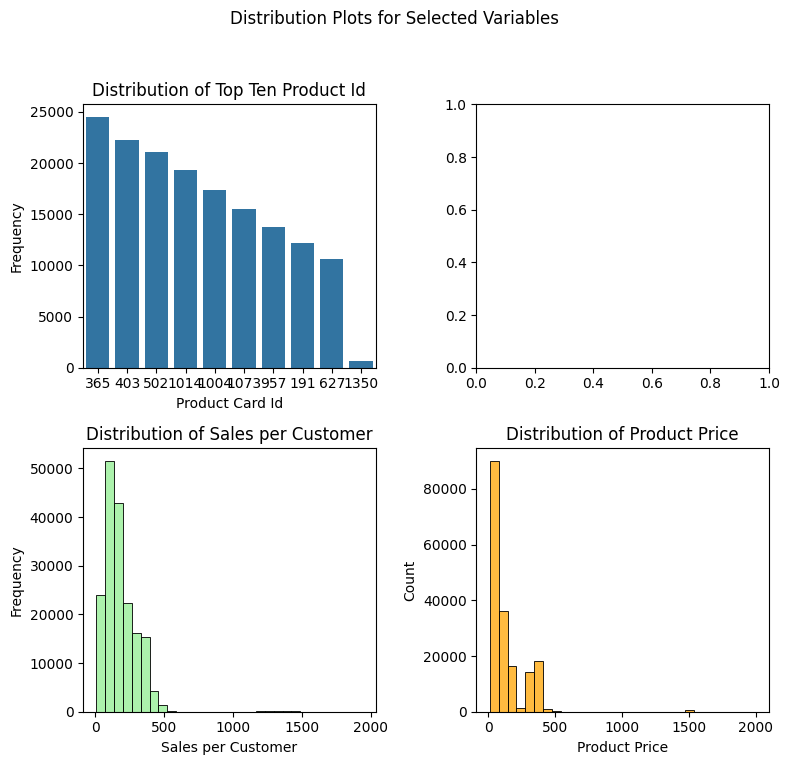

In [173]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
fig.suptitle('Distribution Plots for Selected Variables', fontsize=12)

df_copy =df.copy()

#Top 10 products as per the count
sns.countplot(data=df_copy, x='Product Card Id', ax=axes[0,0],
              order=df_copy['Product Card Id'].value_counts().iloc[:10].index)
axes[0,0].set_title('Distribution of Top Ten Product Id')
axes[0,0].set_xlabel('Product Card Id')
axes[0,0].set_ylabel('Frequency')

#Sales per customer Distribution
sns.histplot(data=df_copy, x='Sales per customer', bins=30, color='lightgreen', ax=axes[1,0])
axes[1,0].set_title('Distribution of Sales per Customer')
axes[1,0].set_xlabel('Sales per Customer')
axes[1,0].set_ylabel('Frequency')

#Product Price Distribution
sns.histplot(data=df_copy, x='Product Price', bins=30, color='orange', ax=axes[1,1])
axes[1,1].set_title('Distribution of Product Price')
axes[1,1].set_xlabel('Product Price')

plt.tight_layout(rect=[0,0.03, 1, 0.95])

From the visuals, we find that:

The product name, Prefect Fitness's Perfect Rip Deck, is associated with the top selling product ID, 365, indicating a high-volume item.

Both the sales value and sales per customer distributions have a long tail and are favorably biased. This suggests that low-value products account for the majority of sales. This is an intriguing finding since it might imply that most consumers are price conscious.

Additionally, the Product Price distribution has a lengthy tail and is favorably skewed. This indicates that the vast majority of goods are of low value.

Note: In light of the univariate analysis's revelation. The top-selling Product Card ID (365 'Perfect Fitness Perfect Rip Deck') will be the concentrate of the remaining study and predictions.

In [174]:
# Exploratory Time Series Visualization

# To understand the demand patterns of the top-selling product, let's create a time series lineplot to visualize the demand patterns of the top-selling product over time.

/tmp/ipython-input-175-1780979211.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_lineplot.resample('M').sum()


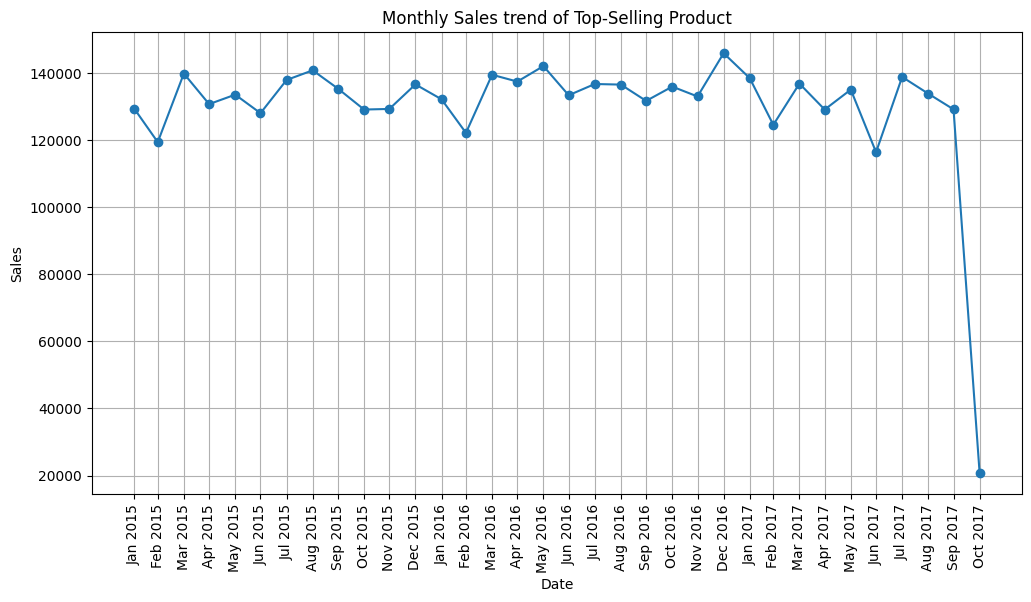

In [175]:
top_product_data = df[df['Product Card Id']== 365]
df_lineplot = top_product_data[['shipping date (DateOrders)', 'Sales']]

#Sales 'order date(DateOrders)' as index
df_lineplot.set_index('shipping date (DateOrders)', inplace= True)

# Resample to monthly frequency and sum the sales
monthly_sales = df_lineplot.resample('M').sum()

#Plot the time series line plot
plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index, monthly_sales['Sales'], marker='o', linestyle='-')
plt.title('Monthly Sales trend of Top-Selling Product')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)

#Format the x-axis tick labels to display month and year
plt.xticks(monthly_sales.index, [x.strftime('%b %Y') for x in monthly_sales.index], rotation=90)
plt.show()

In [176]:
# The demand for the top-selling product exhibits a consistent pattern over time, as indicated by the line plot. Surprisingly, sales figures for 2015 and 2016 were quite stable. In July 2017, however, there is a noticeable drop in sales. Furthermore, there were no orders placed for this product in 2018.

# We can investigate this intriguing finding in further detail.

# Using Prophet to Forecast Demand

# Prophet is a method for time series data forecasting that uses an additive model to suit non-linear trends including daily, weekly, and annual seasonality as well as holiday impacts. Facebook's Core Data Science team released Prophet as open source software.
# The top-selling Product Card Id (365 'Perfect Fitness Perfect Rip Deck') will be the main focus of the forecasting.
#Let's start the procedure...

In [192]:
prophet_data = top_product_data.copy()
prophet_data = prophet_data.rename(columns={'shipping date (DateOrders)': 'ds' ,'Sales' : 'y'})

holidays_df =pd.read_excel('US-Pr-Holidays.xlsx')
holidays_df = holidays_df.rename(columns={'Date':'ds',
                                          'Name':'holiday'})
holidays_df['ds'] = pd.to_datetime(holidays_df['ds'])
holidays_df= holidays_df.drop(columns=['Country','Year'])

#Add 'lower_window' and 'upper_window' columns
holidays_df['lower_window']=0
holidays_df['upper_window']=1

#prophet_data.plot(x='ds', y='y', figsize=(18,6))


In [193]:
prophet_data.shape

(24515, 41)

In [194]:
model = Prophet(holidays=holidays_df)
model.fit(prophet_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw5mar4ku/1fjegto6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw5mar4ku/2wnrw633.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2441', 'data', 'file=/tmp/tmpw5mar4ku/1fjegto6.json', 'init=/tmp/tmpw5mar4ku/2wnrw633.json', 'output', 'file=/tmp/tmpw5mar4ku/prophet_model4wge1l5h/prophet_model-20250729134259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:42:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:43:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [197]:
# Dataframe with future dates for forecasting
future_dates = model.make_future_dataframe(periods=730, freq='D')
forecast = model.predict(future_dates)
forecast.shape

(20843, 88)

In [199]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (observed)', 'Christmas Day (observed)_lower',
       'Christmas Day (observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Constitution Day', 'Constitution Day_lower',
       'Constitution Day_upper', 'Discovery Day', 'Discovery Day_lower',
       'Discovery Day_upper', 'Discovery Day (observed)',
       'Discovery Day (observed)_lower', 'Discovery Day (observed)_upper',
       'Emancipation Day', 'Emancipation Day_lower', 'Emancipation Day_upper',
       'Emancipation Day (observed)', 'Emancipation Day (observed)_lower',
       'Emancipation Day (observed)_upper', 'Epiphany', 'Epiphany_lower',
       'Epiphany_upper', 'Good Friday', 'Good Friday_lower',
       'Good Friday_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (observ

The code mentioned earlier models the demand for the best-selling product using the Prophet library. The Sales and Shipping Date Columns are used to train the model. The demand for the best-selling product over the following 730 days is then predicted using the algorithm.

In order to correct for the impact of holidays on the demand for the best-selling goods, the code additionally included holidays in the US and PR. This is important since demand patterns can be significantly impacted by holidays.

The predicted values for the best-selling product are now included in the forecast variable. We will work on it later, but first, let's assess our prophet model's accuracy.

In [ ]:
# Evaluating the Accuracy of the Time Series Forecast
# To determine the accuracy of the prophet model, we will use the cross_validation() function provided by Prophet

In [200]:
from prophet.diagnostics import cross_validation, performance_metrics

In [203]:
cv = cross_validation(model=model, initial='365 days', period='365 days', horizon='365 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2016-10-08 07:52:00 and 2016-10-08 07:52:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpw5mar4ku/wz61bneq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw5mar4ku/r4fsp15t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46977', 'data', 'file=/tmp/tmpw5mar4ku/wz61bneq.json', 'init=/tmp/tmpw5mar4ku/r4fsp15t.json', 'output', 'file=/tmp/tmpw5mar4ku/prophet_modeljo4ryojb/prophet_model-20250729134524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:45:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:45:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:

# The cross_validation() function performs cross_validation on the model. A portion of the data is used to train the model, while the remaining data is used to assess the model. This is a useful method for assessing the model's correctness.

#The initial paramter specifies the size of the training set i.e., the model will be trained on the data from the first 365 days.

#The period parameter specifies the frequency of the forecast i.e., a new evaluation window will start every 365 days.

# The horizon parameter sets the forecast horizon for each evaluation period. Here, it's specified as 365 days, meaning the model will make forecast for the next 365 days in each evaluation period.

#let's visualize the performance of the model. The performance_metrics function in the prophet library calculated the below metrics for the cross-valiadated forecasts:

1. MSE: Mean Squared Error
2. RMSE: Root Mean Square Error
3. MAE: Mean Average Error
4. MAPE: Mean Absolute Percentage Error
5.MDAPE: Median Absolute Percentage Error
6. SMAPE: Symmentric mean absolute percentage error

In [204]:
pm = performance_metrics(cv, rolling_window=0)

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


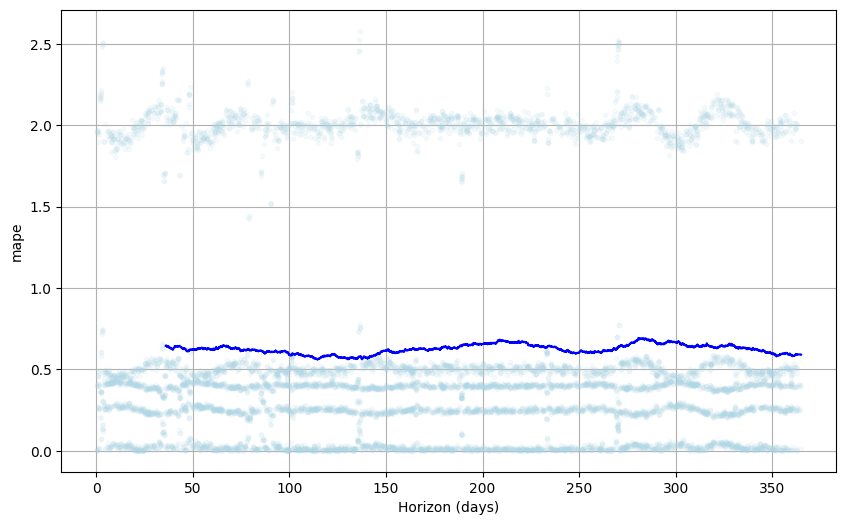

In [205]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(cv, metric='mape');
fig.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')
fig.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')

In [206]:
# Here, we will consider only MAPE, because, it provides a clear understanding of the accuracy of the prediction in percentage terms, making it interpretable and comparable across different forecasting modes. Also, taking the mean of these MAPE values will provide an aggregate measure of model performance across all iterations, giving a single repersentative value.

# The forecast has relatively constant MAPE(Mean Absolute Percentage Error) values for horizons within the 365-day range.

# Exposing the model to more historical data may help lower the MAPE significantly. Moreover, let's explore if there are any opportunities to improve the accuracy by finding the best combinations of hyperparameters for the prophet model. I will use a hyperparameter tuning technique to try to optimize the model's performance.

# Let's do this...

In [207]:
# Hyper Parameter tuning for improve model accuracy

In [208]:
from sklearn.model_selection import ParameterGrid

In [209]:
prophet_data = df.copy()
prophet_data = prophet_data.rename(columns={'order date (DateOrders)': 'ds',
                                            'Sales': 'y'})

In [210]:
# Specify hyperparameter values to try

param_grid = {
    'seasonality_mode' : ["additive", "multiplicative"],
    'seasonality_prior_scale':[0.1,0.5,1,5,10],
    'holidays_prior_scale':[1,2,5,10,15],
    'changepoint_prior_scale':[0.005,0.001,0.01,0.05,0.1]

}

#Generate all combinations of hyperparameters using ParameterGrid
param_combinations = ParameterGrid(param_grid)

The code above generates a grid of hyperparameters using the sklearn library's ParameterGrid method. The prophet model's hyperparameter combinations vary over the grid.

In contrast, the code that follows assesses the model's correctness for every set of hyperparameters using the cross_validation() method. The hyperparameter combination that yields the lowest MAPE is then chosen by the code.

We will only look at MAPE in this case since it makes it easy to evaluate and compare the accuracy of the predictions across various forecasting models by expressing them as a percentage. Additionally, a single representative value representing the overall performance of the model throughout all iterations can be obtained by taking the mean of these MAPE values.

NOTE: It will take a long time to finish the code. It will experiment with 250 different hyperparameter combinations, and the model with the lowest MAPE value will be the best one.



In [211]:
# To compute the Cartesian product of input iterables.
from itertools import product


In [ ]:
results = {}
print(f"Trying all {len(param_combinations)} hyperparameter combinations")

# Generate all combinations of hyperparameters (This creates a list of tuples, where each tuple represents a unique combination of hyperparameters.)
param_combinations = list(product(*param_grid.values()))

for i in param_combinations:
    #Prophet instance with current parameter combination
    p = Prophet(**dict(zip(param_grid.keys(), i)))

    #Fit the model
    p.fit(prophet_data)

    #Cross Validation
    cv = cross_validation(model=p, initial='365 days', period='365 days', horizon='365 days')

    #Performance metrics
    per_metrics = performance_metrics(cv, rolling_window=0)

    #Store metrics in the results dictionary
    results[i] = per_metrics['mape'].mean()

Trying all 250 hyperparameter combinations


DEBUG:cmdstanpy:input tempfile: /tmp/tmpw5mar4ku/q22d0qtq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw5mar4ku/ae1k0g_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65558', 'data', 'file=/tmp/tmpw5mar4ku/q22d0qtq.json', 'init=/tmp/tmpw5mar4ku/ae1k0g_e.json', 'output', 'file=/tmp/tmpw5mar4ku/prophet_modelbpfduiya/prophet_model-20250729134614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:46:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


In [ ]:
results

In [ ]:
#Hyperparameters with the lowest MAPE
best_hyperparams = min(results, key=results.get)
print(f"Best Hyperparameters: {dict(zip(param_grid.keys(), best_hyperparams))}")


Now let’s rebuild the model with the best hyperparameters and evaluate the model’s performance.

In [ ]:
tuned_model = Prophet(holidays=holidays_df,
                      seasonality_mode= 'additive',
                      seasonality_prior_scale=5,
                      holidays_prior_scale=1,
                      changepoint_prior_scale=0.95)

#Fit the model
tuned_model.fit(prophet_data)

#DataFrame with future dates for forecasting
future = tuned_model.make_future_dataframe(periods=730, freq='D')

# Generate forecasts
new_forecast = tuned_model.predict(future)

In [ ]:
#Preform Cross Validation
tuned_cv = cross_validation(model=tuned_model, initial='365 days', period='365 days', horizon='365 days')


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for the first cross-validation metric (before hyperparameter tuning)
fig1 = plot_cross_validation_metric(cv, metric='mape', ax=axs[0])
fig1.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig1.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges
# add title
axs[0].set_title('Initial Cross-Validation score MAPE')

# Plot for the second cross-validation metric (after hyperparameter tuning)
fig2 = plot_cross_validation_metric(tuned_cv, metric='mape', ax=axs[1])
fig2.get_axes()[1].get_lines()[1].set_markerfacecolor('#ADD8E7')  # Change color of the dots
fig2.get_axes()[1].get_lines()[1].set_markeredgecolor('#ADD8E7')  # Change color of the dot edges
# add title
axs[1].set_title('Tuned Cross-Validation score MAPE')

plt.tight_layout()
plt.show()


We can see that the MAPE values does not have any changes than the initial model. I also tried different combinations manually to see if the result changes. But it remained the same. From this we can say that the model is not sensitive to the hyperparameters. The model can still be used for forecasting demand for the top-selling product.

Forecast results
The new_forecast variable contains the forecasted values of our Sales time series. Based on this forecast we will calculate the optimal inventory policy for this specific product.

The new_forecast variable is a dataframe that contains the following columns:

In [ ]:

new_forecast.columns


In [ ]:
# Visualizing Forecasted Sales
tuned_model.plot_components(new_forecast);


In [ ]:
plt.figure(figsize=(18, 6))
# Plot the forecast before 2018 in blue
plt.plot(new_forecast[new_forecast['ds'] < '2018-01-01']['ds'], new_forecast[new_forecast['ds'] < '2018-01-01']['yhat'], linestyle='-', color='blue')
# Plot the forecast after 2018 in red
plt.plot(new_forecast[new_forecast['ds'] >= '2018-01-01']['ds'], new_forecast[new_forecast['ds'] >= '2018-01-01']['yhat'], linestyle='-', color='green')

# plt.xlabel('Date')
# plt.ylabel('Sales')
plt.title('Daily Sales Forecast for Next 24 Months')
plt.grid(True)
# plt.legend()
plt.show()

Lets answer the below question:

What is the demand forecast for the top selling product in the next 24 months?
The sales trend between 2015 and 2017 marks a cycle where sales for the product remained fluctuating all the time with a sharp increase between September and December.

The forecasted sales for the next 24 months, on the other hand, indicate a stable increasing demand pattern.

The minimun variance observed in the product price may account for the relatively stable sales pattern forecasted for 2018 and 2019. It might also be worth investigating the factors that may account for the fluctuations between 2015 and 2017

We can also observe the impact of the US and Puerto Rican holidays on the forecasted sales.

What is the optimal inventory level for the top selling product?
Lets find out !!
~ Finding Optimal Inventory Policy Based on Forecasted Demand ~
Now that we have forecasted the demand for the top-selling product, we can use the forecasted demand to calculate the optimal inventory policy for the product.

Finding the optimal inventory policy will help us determine the Reorder Point, Safety stock, and Economic Order Quantity(EOQ) for the product. These markers will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.


Reorder Point (ROP) -
A reorder point (ROP) is a specific level at which your stock needs to be replenished. In other words, it tells you when to place an order so you won’t run out of stock. Setting a reorder point helps you optimize your inventory, replenish your stock of individual items at the right time, and meet your market demand without going out of stock.

To calculate ROP, we need:

Average sales per day: How much of this item are you selling every day?

Lead time: The Lead Time with regards to the ROP is the time it takes for a product to be delivered by upstream supply chain manufacturers to the store's warehouse i.e. It is the time taken (in days) for your vendor to fulfill your order. The current dataset only provides the Days for shipment (scheduled) and the Days for shipping (real) which only helps us determine downstream lead times. The downstream lead time is the time it takes for a product to be delivered to the customer after it has been ordered. This is not the lead time we need to calculate the reorder point. So for the purposes of our analysis we will assume an average upstream Lead time of 6 days.

Safety stock: The amount of extra stock,, that you would keep in your inventory to help avoid stockouts due to uncertainties in demand and lead time.

The formula for ROP is:

       Reorder point = lead time demand + safety stock
where the Lead Time Demand is calculated as:

Lead Time Demand = average sales per day * lead time
and the safety stock is calculated as:

       Safety stock = (maximum daily sales * maximum lead time) – lead time demand
As explained above, lets also assume that there have been delays from the manufacturer in the past and the maximum lead time is 10 days i.e 4 days later than the average order fulfillment timeline.

Note: All this is been done for the top selling product (by order frequency) i.e Perfect Fitness Perfect Rip Deck Lets calculate !!

In [ ]:
# CALCULATING LEAD TIME DEMAND

# average forecasted sales
avg_daily_forecasted_sales = new_forecast['yhat'].mean().round(3)
print(f"Average Daily Forecasted Sales: {avg_daily_forecasted_sales}")

# assumed average lead time (in days)
avg_lead_time = 6
print(f"Average Lead Time: {avg_lead_time}")

# lead time demand
lead_time_demand = avg_daily_forecasted_sales * avg_lead_time
print(f"Lead Time Demand: {lead_time_demand}")

In [ ]:
# CALCULATING SAFETY STOCK

# maximum daily sales
max_daily_forecasted_sales = new_forecast['yhat'].max().round(3)
print(f"maximum Daily Forecasted Sales: {max_daily_forecasted_sales}")

# assumed max lead time (in days)
max_lead_time = 10
print(f"Average Lead Time: {max_lead_time}")

safety_stock = (max_daily_forecasted_sales * max_lead_time) - lead_time_demand
print(f"Safety Stock: {safety_stock.round(3)}")

In [ ]:
# CALCULATING ROP
rop = lead_time_demand + safety_stock
print(f"The Optimal Reorder Point for the Top-selling Product is: {rop}")

The observed outcome suggests that the optimal reorder point for our highest-selling product (Perfect Fitness Perfect Rip Deck) is 2149 units. This suggests that when we have only 2149 units left in stock, we should initiate restocking procedures to make sure we always have enough for customers. Maintaining stock above this quantity ensures sufficient supply to meet customer demand while also optimizing inventory management costs.

Economic Order Quantity (EOQ) -
Economic order quantity (EOQ) model is another method to determine the optimal order quantity / inventory reorder point. It is the ideal quantity of units a company should purchase to meet demand while minimizing inventory costs such as holding costs, shortage costs, and order costs. The economic order quantity formula assumes that demand, ordering, and holding costs all remain constant. Assuming demand for the products as constant sometimes results as one of the limitations of this method. This method helps make efficient inventory management decisions.

Unlike the Reorder Point which is concerned with determining the level of inventory at which a new order should be placed to avoid stockouts, EOQ takes into account the costs of ordering (e.g., setup costs) and the costs of holding inventory (e.g., storage costs, opportunity costs).

The Economic Order Quantity (EOQ) formula is given by:



where:

Q: EOQ units
D: Demand in units,
S: Ordering cost per order,
H: Holding cost per unit per year.
Economic order quantity (EOQ) will be higher if the ordering costs or product demand increases. On the other hand, it will be lower if the company’s holding costs increase.

Ordering Cost:

NOTE: We can figure out the demand rate ( D ) based on the existing data. However, the ordering cost ( S ) and holding cost ( H ) are not provided in the dataset. For our analysis, We will assume that the ordering and holding cost is 10% and 25% of the product price respectively.

In [ ]:
# product price
product_price = top_product_data['Product Price'].iloc[0]
print(f"The Product Price is: {product_price}")

# calculate holding cost
H = 0.10 * product_price
print(f"The Holding Cost is: {H}")

# calculate ordering cost
S = 0.25 * product_price
print(f"The Ordering Cost is: {S}")

# calculate forecasted demand rate
D = new_forecast['yhat'].mean()
print(f"The Demand Rate is: {D}")

In [ ]:
EOQ = math.sqrt((2 * D * S) / H)
print(f"The Economic Order Quantity is: {EOQ}")

Hence, according to the EOQ model, the optimal order quantity for the top-selling product is 30 units. This means that we should order 30 units of the product at a time to minimize the total inventory costs. This will help us ensure that we have the right amount of inventory on hand to meet customer demand while minimizing inventory costs.

So here's the answer the second question i.e.

What is the optimal inventory level for the top selling product?
The optimal inventory policy for the top-selling product is as follows:

Reorder point: 2149 Units
Safety stock: 1066 Units
Economic Order Quantity: 30 Units
Thus, when the stock level of the top-selling product hits 2149 units, it's time to order 30 more units from the supplier to keep up with demand and maintain sufficient stock levels. Also, a safety stock of 1066 units should be kept in inventory to avoid stockouts.

Using these strategies for inventory management will help the company keep enough of the best-selling product in stock to meet customer needs while keeping costs low.

SUMMARIZING THE KEY TAKEAWAYS:
The project focused on forecasting the demand and managing inventory for the best selling product according to the order frequency.

We explored how to build a demand forecasting model with Python and evaluate its performance.
We discovered trends, seasonalities and holiday effects on the top-selling product based on the dataset provided.
We used the model for inventory optimization, covering concepts like reorder points, safety stock, and economic order quantity (EOQ).
We found the optimal inventory policy for the top-selling product.